# 1. Import

In [15]:
import pandas as pd
import seaborn as sns
import numpy as np
import pickle

# graph
import pathlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from datetime import datetime


# model
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics

#  for multicolinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor 

# 2. Import Files

In [2]:
# 1. to make sure month and time column is read as string
string_cols = ['Month', 'Time']
dict_dtypes = {x : 'str'  for x in string_cols}

# 2. get all year data
all_year = pd.read_csv('./Data/station.csv', index_col = 0, dtype = dict_dtypes)


In [4]:
Y

01/01/2018 00:00    56.93
01/01/2018 00:15    65.03
01/01/2018 00:30    47.84
01/01/2018 00:45    53.82
01/01/2018 01:00    51.24
                    ...  
12/31/2018 22:00    35.75
12/31/2018 22:15    34.16
12/31/2018 22:30    36.17
12/31/2018 22:45    36.37
12/31/2018 23:00    33.81
Name: CHWTON, Length: 34622, dtype: float64

# 3. Cyclical Features encoding

In [ ]:
# https://www.kaggle.com/avanwyk/encoding-cyclical-features-for-deep-learning
# https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca
# http://blog.davidkaleko.com/feature-engineering-cyclical-features.html

In [5]:
# encode df columns into sine and cosine
def encode(df, col, max_val):
    df[col.replace('_num', '') + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col.replace('_num', '') + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    df.drop(columns = [col], inplace = True)
    return df


In [6]:
X_encode = X.copy(deep=True)
X_encode = encode(X_encode, 'Minute_num', 60.0)
X_encode = encode(X_encode, 'Hour_num', 23.0)
X_encode = encode(X_encode, 'Day_num', 30.0)
X_encode = encode(X_encode, 'Month_num', 12.0)


In [7]:
X_encode

,Air Temp,Rel Humid,KW,Minute_sin,Minute_cos,Hour_sin,Hour_cos,Day_sin,Day_cos,Month_sin,Month_cos
01/01/2018 00:00,11.0,40.24,153.92,0.000000e+00,1.000000e+00,0.000000e+00,1.000000,0.207912,0.978148,5.000000e-01,0.866025
01/01/2018 00:15,11.0,40.24,155.92,1.000000e+00,2.832769e-16,0.000000e+00,1.000000,0.207912,0.978148,5.000000e-01,0.866025
01/01/2018 00:30,10.0,43.01,152.79,5.665539e-16,-1.000000e+00,0.000000e+00,1.000000,0.207912,0.978148,5.000000e-01,0.866025
01/01/2018 00:45,9.0,46.00,155.39,-1.000000e+00,-1.836970e-16,0.000000e+00,1.000000,0.207912,0.978148,5.000000e-01,0.866025
01/01/2018 01:00,9.0,46.00,151.32,0.000000e+00,1.000000e+00,2.697968e-01,0.962917,0.207912,0.978148,5.000000e-01,0.866025
...,...,...,...,...,...,...,...,...,...,...,...
12/31/2018 22:00,6.0,93.30,148.92,0.000000e+00,1.000000e+00,-2.697968e-01,0.962917,0.207912,0.978148,-2.449294e-16,1.000000
12/31/2018 22:15,5.0,100.00,150.79,1.000000e+00,2.832769e-16,-2.697968e-01,0.962917,0.207912,0.978148,-2.449294e-16,1.000000
12/31/2018 22:30,5.0,100.00,151.93,5.665539e-16,-1.000000e+00,-2.697968e-01,0.962917,0.207912,0.978148,-2.449294e-16,1.000000
12/31/2018 22:45,6.0,93.30,144.93,-1.000000e+00,-1.836970e-16,-2.697968e-01,0.962917,0.207912,0.978148,-2.449294e-16,1.000000


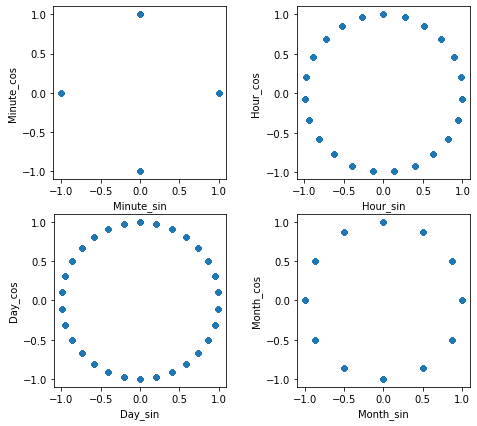

In [8]:
# 1. create firgure for 2 rows 2 columns
fig, ax = plt.subplots(2,2, figsize = (8,7))
X_encode.plot.scatter('Minute_sin', 'Minute_cos', ax = ax[0,0]).set_aspect('equal')
X_encode.plot.scatter('Hour_sin', 'Hour_cos', ax = ax[0,1]).set_aspect('equal')
X_encode.plot.scatter('Day_sin', 'Day_cos', ax = ax[1,0]).set_aspect('equal')
X_encode.plot.scatter('Month_sin', 'Month_cos', ax = ax[1,1]).set_aspect('equal')

# 4. XG Boost

## 4.1 On non-cyclical

In [9]:
# Train test split
# 1. Split into train test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# 2. create an xgboost regression model
XGB = XGBRegressor(n_estimators = 1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

# 3. Train
XGB.fit(X_train, Y_train)

# 4. Predict
R2non = XGB.score(X_test, Y_test)

# 5. Score
R2non = XGB.score(X_test, Y_test)
print('R2 non-cyclical: ',R2non)

In [ ]:
X_train

## 4.2 On Cyclical

In [10]:
# Train test split
# 1. Split into train test data
X_train_encode, X_test_encode, Y_train, Y_test = train_test_split(X_encode, Y, test_size=0.2, random_state=42)

# # 2. create an xgboost regression model
# XGB = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

# # 3. Train
# XGB.fit(X_train_encode, Y_train)

# # 4. Predict & scoreb
# R2 = XGB.score(X_test_encode, Y_test)
# print('R2 cyclical: ', R2)


In [ ]:
Y

# 5. Ada Boost

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.datasets import make_regression

# non cyclical
ADAregr = AdaBoostRegressor(random_state=0, n_estimators=1000)
ADAregr.fit(X_train, Y_train)
R2_ADA_non = ADAregr.score(X_test, Y_test)
print('R2 non-cyclical: ',R2_ADA_non)

In [ ]:
# cyclical
ADAregr.fit(X_train_encode, Y_train)
R2_ADA = ADAregr.score(X_test_encode, Y_test)
print('R2: ',R2_ADA)

# 6. Random RF

In [11]:
from sklearn.ensemble import RandomForestRegressor

In [13]:
# # 1. create an xgboost regression model
base_RF = RandomForestRegressor(n_estimators = 100, random_state = 42)

# 2. Train
base_RF.fit(X_train, Y_train)

# # 4. Predict & scoreb
R2 = base_RF.score(X_test, Y_test)
print('R2 non-cyclical: ', R2)

R2 non-cyclical:  0.9851007364763341


In [14]:

# 3. Train
base_RF.fit(X_train_encode, Y_train)

# 4. Predict & scoreb
R2 = base_RF.score(X_test_encode, Y_test)
print('R2 cyclical: ', R2)

R2 cyclical:  0.9858921496466247


# 7. Randomized Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import time

In [ ]:
# Train test split
# 1. Split into train test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=20)

In [ ]:
# A parameter grid for XGBoost
params = {
    'n_estimators':[ 100 , 250, 500, 1000],
    'min_child_weight':[4,5], 
    'gamma':[i/10.0 for i in range(3,6)],  
    'subsample':[i/10.0 for i in range(6,11)],
    'colsample_bytree':[i/10.0 for i in range(6,11)], 
    'max_depth': [2,3,4,6,7],
    'objective': ['reg:squarederror', 'reg:tweedie'],
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': ['rmse'],
    'eta': [i/10.0 for i in range(3,6)],
}

reg = XGBRegressor()

n_iter_search = 20
xgb_random = RandomizedSearchCV(reg,
       Y                         param_distributions = params,
                                n_iter = n_iter_search,
                                cv = 5,
                                verbose = 2,
                                random_state = 20,
                                scoring ='r2',
                                n_jobs = -1)

start = time.time()
xgb_random.fit(X_train, Y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))



In [ ]:
# 1. print winning set of hyperparameters
print(xgb_random.best_estimator_.get_params())
print(xgb_random.best_score_)

# 2. save model
xgb_best = xgb_random.best_estimator_

In [ ]:
# June 9th prediction
# 1. get X
X_j9_dum = j9_dum.drop(labels = ['CHWTON', 'Month', 'Time'], axis = 1)

# 2. Ypred
Y_pred_xgb_j9 = xgb_best.predict(X_j9_dum)

# 3. Score
R2_j9_xgb = xgb_best.score(X_j9_dum, Y_j9)
RMSE_j9_xgb = np.sqrt(metrics.mean_squared_error(Y_j9, Y_pred_xgb_j9))

# 4. append to score df
score_J9_xgb = [R2_j9_xgb, RMSE_j9_xgb]
scores_df['XGB_J9_AZ'] = score_J9_xgb
scores_df